In [119]:
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load and preprocess data ===
with open("combined_data.json", "r") as f:
    data = json.load(f)

x_g = np.array(data["interpolated_data"]["g"])
x_r = np.array(data["interpolated_data"]["r"])
mask_g = np.array(data["mask_data"]["g"])
mask_r = np.array(data["mask_data"]["r"])
labels = data["mergedType"]
label_map = {'Ia': 0, 'II': 1, 'Ibc': 1, 'Other': 1}
# label_map = {'Ia': 0, 'II': 1, 'Ibc': 2, 'Other': 3}
y = np.array([label_map[l] for l in labels])

def masked_standardize(x, mask):
    obs = x[mask == 1]
    mean = obs.mean()
    std = obs.std()
    x_norm = np.zeros_like(x)
    x_norm[mask == 1] = (x[mask == 1] - mean) / (std + 1e-8)
    return x_norm

x_g_std = masked_standardize(x_g, mask_g)
x_r_std = masked_standardize(x_r, mask_r)
X = np.stack([x_g_std, x_r_std], axis=1)      # (N, 2, 100)
mask = np.stack([mask_g, mask_r], axis=1)     # (N, 2, 100)


In [132]:
class TransformerDataset(Dataset):
    def __init__(self, X, mask, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.bool)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.mask[idx], self.y[idx]

dataset = TransformerDataset(X, mask, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [134]:
class DualTransformerClassifier(nn.Module):
    def __init__(self, seq_len=100, input_dim=1, model_dim=64, num_heads=2, num_layers=2, num_classes=2, dropout=0.5):
        super().__init__()

        def build_branch():
            return nn.Sequential(
                nn.Linear(input_dim, model_dim),
                # nn.LayerNorm(model_dim)
            )

        self.g_proj = build_branch()
        self.r_proj = build_branch()
        self.pos_encoding = self._build_positional_encoding(seq_len, model_dim)

        encoder_layer = lambda: nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.encoder_g = nn.TransformerEncoder(encoder_layer(), num_layers=num_layers)
        self.encoder_r = nn.TransformerEncoder(encoder_layer(), num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(model_dim * 2 * seq_len, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def _build_positional_encoding(self, seq_len, model_dim):
        pe = torch.zeros(seq_len, model_dim)
        position = torch.arange(0, seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2) * (-torch.log(torch.tensor(10000.0)) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # shape: [1, T, D]

    def forward(self, x, mask):
        # x: [B, 2, T], mask: [B, 2, T]
        x = x.permute(0, 2, 1)  # → [B, T, 2]
        x_g = x[:, :, 0:1]      # [B, T, 1]
        x_r = x[:, :, 1:2]      # [B, T, 1]
        m_g = ~mask[:, 0, :]    # [B, T], True = mask
        m_r = ~mask[:, 1, :]

        # 投影 + PE
        xg = self.g_proj(x_g) + self.pos_encoding[:, :x_g.size(1), :].to(x_g.device)
        xr = self.r_proj(x_r) + self.pos_encoding[:, :x_r.size(1), :].to(x_r.device)

        # 各自 transformer 编码器
        out_g = self.encoder_g(xg, src_key_padding_mask=m_g)
        out_r = self.encoder_r(xr, src_key_padding_mask=m_r)

        # 展平 + 拼接
        out = torch.cat([out_g, out_r], dim=2)  # [B, T, 2D]
        return self.classifier(out.reshape(out.size(0), -1))  # [B, num_classes]

In [127]:
# 假设你有 dataset (就是之前定义的那个SupernovaDataset)
# 统计所有label
all_labels = []
for i in range(len(dataset)):
    _, _, label = dataset[i]
    all_labels.append(label.item())

all_labels = np.array(all_labels)
classes, counts = np.unique(all_labels, return_counts=True)

# 打印一下每类数量
print("Class counts:", dict(zip(classes, counts)))

# 计算权重
total_samples = len(all_labels)
class_weights = total_samples / (len(classes) * counts)  # 标准公式

class_weights = np.clip(class_weights, 0.5, 10.0)  # 最小1.0，最大5.0
class_weights = torch.tensor(class_weights, dtype=torch.float32)
# 转为torch tensor

print("Class weights:", class_weights)

Class counts: {np.int64(0): np.int64(4755), np.int64(1): np.int64(1465)}
Class weights: tensor([0.6540, 2.1229])


In [90]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha  # 权重张量
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # pt 是预测概率
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [137]:
# === Step 4: 训练设置 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualTransformerClassifier(num_classes = len(class_weights)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(alpha=class_weights.to(device), gamma=1.8)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_acc, best_state = 0, None

# === Step 5: 训练循环 ===
for epoch in range(20):
    model.train()
    correct, total, loss_sum = 0, 0, 0
    for xb, mb, yb in train_loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb, mb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        loss_sum += loss.item() * yb.size(0)
        total += yb.size(0)
    train_losses.append(loss_sum / total)
    train_accs.append(correct / total)

    # === 测试 ===
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, mb, yb in test_loader:
            xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
            out = model(xb, mb)
            loss = criterion(out, yb)
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            loss_sum += loss.item() * yb.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            total += yb.size(0)
    test_losses.append(loss_sum / total)
    test_accs.append(correct / total)

    if test_accs[-1] > best_acc:
        best_acc = test_accs[-1]
        best_state = model.state_dict()

# === Step 6: 可视化 ===
model.load_state_dict(best_state)
model.eval()
correct, total = 0, 0
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for xb, mb, yb in test_loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
        out = model(xb, mb)
        probs = torch.softmax(out, dim=1)
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        total += yb.size(0)
    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")



Test Accuracy: 0.8955


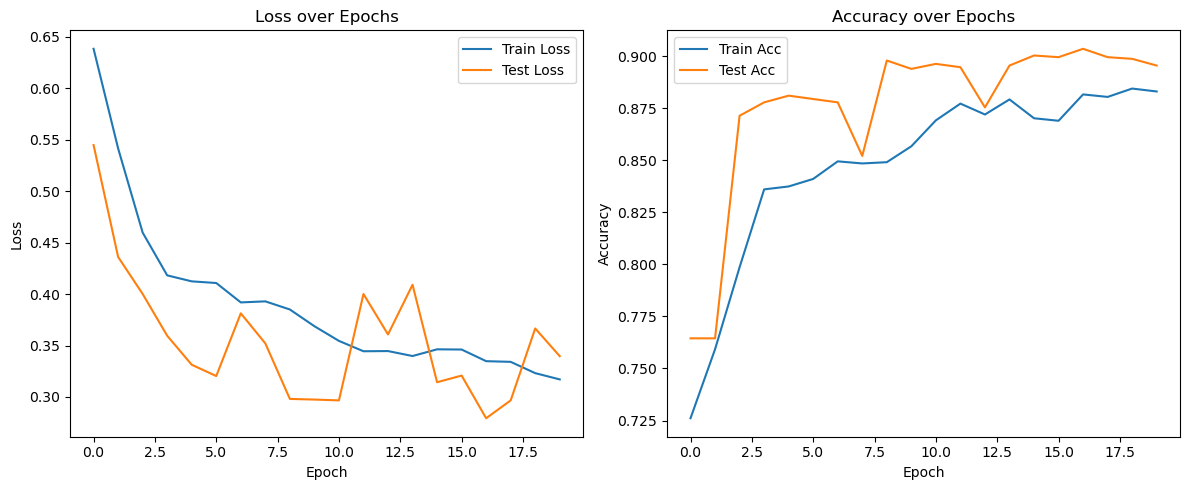

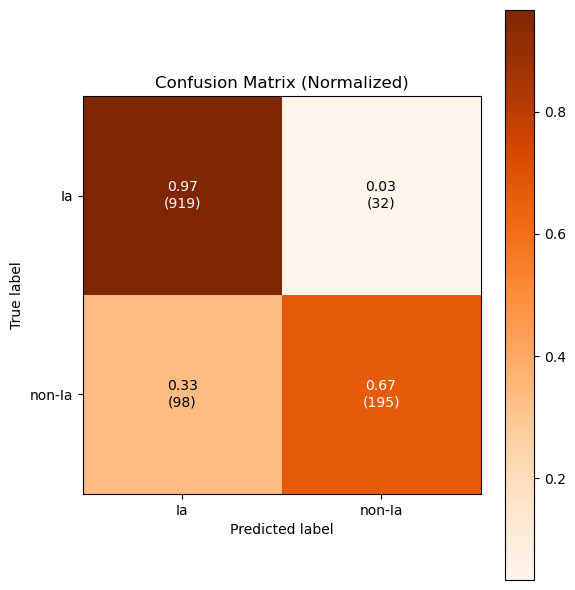

In [138]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# 可视化
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Oranges)
plt.colorbar(im, ax=ax)

# 设置标签
# classes = ['Ia', 'II', 'Ibc', 'Other']  # 自定义类别名称
classes = ['Ia', 'non-Ia']  # 自定义类别名称
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (Normalized)'
)

# 显示数值 + 真实数量
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm_normalized[i, j]
        count = cm[i, j]
        ax.text(j, i, f'{value:.2f}\n({count})',
                ha="center", va="center",
                color="white" if value > thresh else "black")

plt.tight_layout()
plt.show()


F1 Score: 0.7500
AUC Score: 0.9091


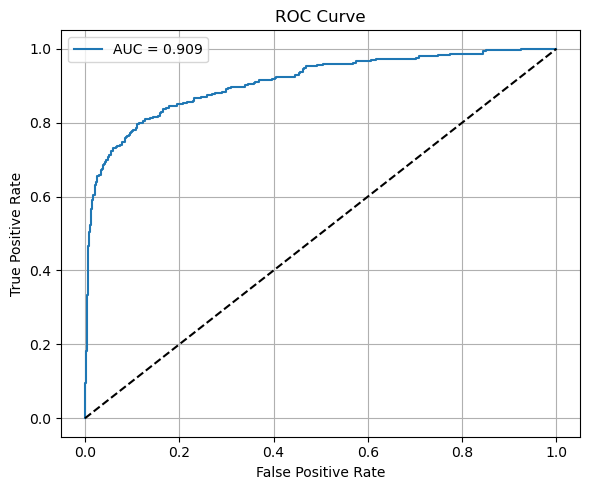

In [139]:
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
# from scipy.special import softmax  # 若输出为logits则手动加

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
num_classes = y_prob.shape[1]

# 二分类则用 binary方式
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    auc_val = auc(fpr, tpr)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nF1 Score: {f1:.4f}")
    print(f"AUC Score: {auc_val:.4f}")
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    # 多分类处理
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    f1 = f1_score(y_true, y_pred, average='macro')
    # auc_val = roc_auc_score(y_true_bin, y_prob, average='macro')
    auc_val = roc_auc_score(y_true_bin, y_prob, average='weighted')
    print(f"\nMacro F1 Score: {f1:.4f}")
    print(f"Weighted AUC Score: {auc_val:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_i = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_i:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Class")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [140]:
import numpy as np

def convert_to_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.integer)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.floating)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_json_serializable(v) for v in obj]
    else:
        return obj

Comb = {
    "all-labels": all_labels,
    "all-preds": all_preds,
    "all-probs": all_probs,
}

with open("two-class_transformer.json", "w") as f:
    json.dump(convert_to_json_serializable(Comb), f, indent=2)